In [25]:
import numpy as np
import tensorflow as tf
from keras import models, layers, optimizers
from tensorflow.keras.losses import SparseCategoricalCrossentropy
# from keras_tuner import HyperParameters, RandomSearch

# data manipulation
# from keras.utils import to_categorical
# from imblearn.over_sampling import RandomOverSampler, SMOTE
# from imblearn.under_sampling import RandomUnderSampler

# data processing
from sklearn import preprocessing
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pandas as pd
import csv

# plotting
import matplotlib.pyplot as plt
import seaborn as sb

import os
for dirname, _, filenames in os.walk('backend/data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

### uncomment to download complete dataset
# import kagglehub
# path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000") # skin cancer dataset
# print("Path to dataset files:", path)

### Processing Data

In [26]:
meta_data = pd.read_csv(r'data\HAM10000_metadata.csv')
sex = np.array(pd.get_dummies(meta_data["sex"]))
localization = np.array(pd.get_dummies(meta_data["localization"]))
age = np.array(meta_data["age"])

In [27]:
### save dummy headers
# dummy_cols = pd.get_dummies(meta_data["localization"])
# print(localization)
# print(dummy_cols)
# dummy_cols.columns.to_series().to_csv('local_dummies_columns.csv', index=False)

In [28]:
# convert age values to interval classes
# <30: young adult  0
# <50: middle age   1
# else: senior      2
for i in range(len(age)):
    if age[i] < 30:
        age[i] = 0
    elif age[i] < 50:
        age[i] = 1
    else:
        age[i] = 2

In [29]:
data = pd.read_csv(r'data\hmnist_28_28_RGB.csv')
# print(data.head())

y = data['label']
y_labels = ('akiec','bcc','bkl', 'df','nv','vasc', 'mel') # according to labels in dataset

X = data.drop(["label"], axis=1) # axis 1 is whole columns
X = np.array(X) # convert to np array
X = np.column_stack((X, age))
X = np.column_stack((X, sex))
X = np.column_stack((X, localization))
# print("np.shape:", np.shape(X))

# normalize using scikit learn lib
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) # 20% of whole dataset is test, rest is training
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2) # 20% of training dataset is validation

# valid = (X_valid, y_valid)

In [30]:
# print(np.shape(age))
# print(np.shape(sex))
# print(np.shape(localization))
# print(np.shape(X[0]))
# print(len(X[0]))

In [31]:
# print(y_labels)
# print(X.shape)

### Apply Neural Network

In [32]:
model = models.Sequential([
    # initialize with glorot to avoid exploding/vanishing weights
    layers.Dense(units = 128,input_dim = len(X_train[0]), activation = 'relu', kernel_initializer=tf.keras.initializers.GlorotNormal()),
    layers.Dense(units = 64, activation = 'relu'),
    layers.Dense(units = 32, activation = 'relu'),
    layers.Dense(units = 16, activation = 'relu'),
    layers.Dense(units = len(y_labels), activation = 'softmax')
])

#loss
model.compile(optimizer = optimizers.Adam(learning_rate=.5e-3), loss = SparseCategoricalCrossentropy(),metrics=['accuracy']) # metrics to be shown = acc

def lr_scheduler(epoch, lr):
    if epoch < 3:
        return lr
    return lr * 0.88 # Reduce the learning rate by 12% after 3rd epoch
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=3) # reduce by 60% when plateauing for 3 epochs

early_stopping = EarlyStopping(monitor='val_loss', patience=4,restore_best_weights=True)

#fit
history = model.fit(X_train,y_train,epochs = 16, batch_size=32, callbacks=[early_stopping, LearningRateScheduler(lr_scheduler), reduce_lr]) #, validation_data=valid

train_loss = history.history["loss"]
# val_loss = history.history["val_loss"]

c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/16
251/251 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6556 - loss: 1.0687 - learning_rate: 5.0000e-04
Epoch 2/16
 37/251 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7166 - loss: 0.8033

c:\Python312\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
c:\Python312\Lib\site-packages\keras\src\callbacks\callback_list.py:151: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7012 - loss: 0.8267 - learning_rate: 5.0000e-04
Epoch 3/16
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7230 - loss: 0.7552 - learning_rate: 5.0000e-04
Epoch 4/16
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7504 - loss: 0.6920 - learning_rate: 4.4000e-04
Epoch 5/16
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7609 - loss: 0.6512 - learning_rate: 3.8720e-04
Epoch 6/16
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7785 - loss: 0.5981 - learning_rate: 3.4074e-04
Epoch 7/16
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7938 - loss: 0.5634 - learning_rate: 2.9985e-04
Epoch 8/16
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8145 - loss: 0.5232 - learning_rate: 2.6387e-04
Epoch 9/16
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8250 - loss: 0.4855 - learning_rate: 2.3220e-04
Epoch 10/16
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8435 - loss: 0.4479 - learning_r

C:\Users\Alex\AppData\Local\Temp\ipykernel_19544\2600280914.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, train_loss[cropping_num:], 'b', label='Training loss', color= "cornflowerblue")


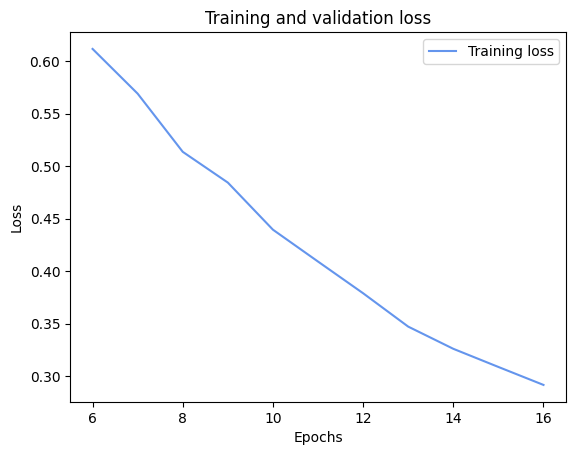

In [33]:
train_loss = history.history["loss"]
# val_loss = history.history["val_loss"]

cropping_num = 5
epochs = range(cropping_num+1, len(train_loss) + 1)
plt.plot(epochs, train_loss[cropping_num:], 'b', label='Training loss', color= "cornflowerblue")
# plt.plot(epochs, val_loss[cropping_num:], 'b', label='Validation loss', color= "orange")
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


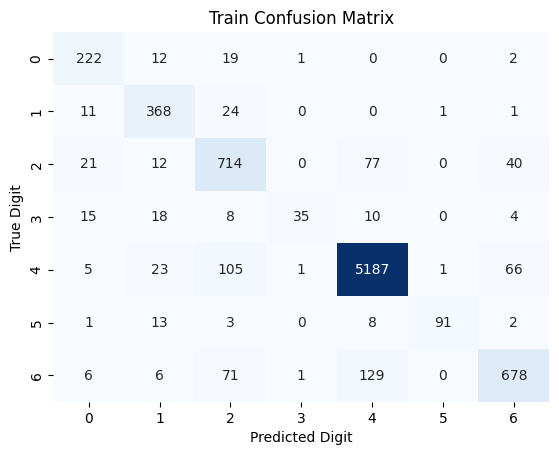

In [34]:
train_pred = np.argmax(model.predict(X_train), axis=1)
train_confusion_matrix = confusion_matrix(y_train, train_pred)

# Plot Train heatmap
sb.heatmap(train_confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f"Train Confusion Matrix")
plt.xlabel("Predicted Digit")
plt.ylabel("True Digit")
plt.show()

In [35]:
test_results = model.evaluate(X_test, y_test, return_dict=True, verbose=0)
test_acc = test_results['accuracy']
print("Test Accuracy:",test_acc)

Test Accuracy: 0.748876690864563


In [36]:
model.save("skin_cancer_detection_modelv2.keras")